In [4]:
!find ../../images-desi-lowz-extended -type f -print0 | xargs -0 ls -l | awk '{size[int(log($5)/log(2))]++}END{for (i in size) printf("%10d %3d\n", 2^i, size[i])}' | sort -n

         0   1
      1024  38
      2048  20
      4096  35
      8192 101643
     16384 1753103
     32768  38


         0   1
      1024  38
      2048  20
      4096  35
      8192 101643
     16384 1753103
     32768  38

# Load learner

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from pathlib import Path

from mish_cuda import MishCuda
import cmasher as cmr
import gc
import scipy.cluster.hierarchy as hcluster

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tqdm.notebook as tqdm

seed = 256

%matplotlib inline

In [2]:
import sys
PATH = Path('../..').resolve()

sys.path.append(f'{PATH}/src')
from utils import *

learner_metrics = [accuracy, F1Score(), Recall(), Precision()]

sys.path.append('/home/jupyter/morphological-spectra/src')
from xresnet_deconv import *

In [7]:
# https://github.com/fastai/fastai/blob/master/fastai/losses.py#L48
class FocalLossFlat(CrossEntropyLossFlat):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al.
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be
    implemented through pytorch `weight` argument in nn.CrossEntropyLoss.
    """
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, axis=-1, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss


In [8]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1, random_state=seed).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1


label_column = 'low_z'

# focal loss weight params
gamma = 2
loss_func = FocalLossFlat(gamma=gamma)

sz = 144
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [9]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/images-legacy_saga-2021-02-19/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

model = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=loss_func,
)
learn.load(f'{PATH}/models/desi-sv_FL-hdxresnet34-sz{sz}');

# Get all filenames

In [10]:
filenames = list(x for x in (PATH/'images-desi-lowz-extended').rglob('*.jpg') if (x.stat().st_size > 0))
len(filenames)

1854877

# Make predictions for the north

In [11]:
dn = pd.read_csv(PATH/'data/desi_low_z_extended_target_list_north_dr9.csv', index_col=0)
dn.shape

(464128, 147)

In [12]:
dn['objname'] = (dn.RA * 1000000).astype(int).astype(str) + (dn.DEC * 1000000).astype(int).astype(str)

In [13]:
north_filenames = dn.objname[dn.objname.isin([x.stem for x in filenames])].values
north_filenames.shape

(464128,)

In [14]:
dn = dn.set_index('objname').loc[north_filenames].reset_index()
dn.head()

,objname,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,...,z_mag,z_err,r_fib_mag,u_mag,u_err,i_mag,i_err,mu_r,mu_r_err,bgs
0,37067673-2685653,9011,314676,b'0371m027',356,b'REX',37.067673,-2.685653,3.109144e+11,3.462317e+11,...,99.0,99.0,20.336999,99.0,99.0,99.0,99.0,20.596599,0.018950,False
1,37110556-2675984,9011,314676,b'0371m027',586,b'EXP',37.110557,-2.675985,3.827715e+11,2.105431e+11,...,99.0,99.0,20.388507,99.0,99.0,99.0,99.0,21.437355,0.017676,False
2,37153056-2631961,9011,314676,b'0371m027',835,b'SER',37.153056,-2.631961,7.085810e+10,8.625275e+10,...,99.0,99.0,21.173093,99.0,99.0,99.0,99.0,22.211661,0.021873,False
3,37156511-2718313,9011,314676,b'0371m027',865,b'REX',37.156511,-2.718313,2.158520e+10,2.392424e+10,...,99.0,99.0,21.835082,99.0,99.0,99.0,99.0,22.252107,0.060735,False
4,37175542-2699230,9011,314676,b'0371m027',998,b'SER',37.175543,-2.699231,3.032719e+11,1.201192e+11,...,99.0,99.0,20.613898,99.0,99.0,99.0,99.0,21.880484,0.018959,False


In [15]:
test_dl_north = dls.test_dl([f'{PATH}/images-desi-lowz-extended/{x}.jpg' for x in north_filenames], num_workers=8, bs=32)

In [16]:
m = learn.model.eval()

outputs = []
with torch.no_grad():
    for (xb,) in tqdm.tqdm(iter(test_dl_north), total=len(test_dl_north)):
        outputs.append(m(xb).cpu())
        
outs = torch.cat(outputs)
ps = outs.softmax(1)


In [17]:
preds_north = pd.DataFrame({
    'objname': north_filenames,
    'p_CNN': ps[:, 1],
})

In [18]:
preds_north.to_csv(PATH/'results/desi-lowz/north_extended-only_CNN-hdx34-sz144_2021-03-20.csv', index=False)

# Make predictions for the south

In [19]:
ds = pd.read_csv(PATH/'data/desi_low_z_extended_target_list_south_dr9.csv', index_col=0)
ds.shape

/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1390985, 148)

In [20]:
ds['objname'] = (ds.RA * 1000000).astype(int).astype(str) + (ds.DEC * 1000000).astype(int).astype(str)

In [21]:
south_filenames = ds.objname[ds.objname.isin([x.stem for x in filenames])].values
south_filenames.shape

(1390916,)

In [22]:
ds = ds.set_index('objname').loc[south_filenames].reset_index()
ds.head()

,objname,Unnamed: 0.1,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,...,z_mag,z_err,r_fib_mag,u_mag,u_err,i_mag,i_err,mu_r,mu_r_err,bgs
0,6271416-370376,781.0,9010,328953,b'0063m002',860,b'EXP',6.271416,-0.370377,3.237160e+11,...,20.010270,0.013074,21.604397,99.0,99.0,99.0,99.0,22.949121,0.015422,False
1,6272609-228331,814.0,9010,328953,b'0063m002',896,b'EXP',6.272609,-0.228332,2.694691e+11,...,20.649603,0.018228,21.700961,99.0,99.0,99.0,99.0,22.273314,0.024737,False
2,6275602-233615,930.0,9010,328953,b'0063m002',1014,b'EXP',6.275602,-0.233616,2.030263e+11,...,20.194250,0.015498,21.624507,99.0,99.0,99.0,99.0,23.012360,0.018376,False
3,6277380-168376,1006.0,9010,328953,b'0063m002',1092,b'REX',6.277381,-0.168376,3.712580e+11,...,20.347836,0.016434,21.611418,99.0,99.0,99.0,99.0,21.675520,0.019594,False
4,6373085-277608,4561.0,9010,328953,b'0063m002',4711,b'SER',6.373086,-0.277608,1.530489e+12,...,19.048900,0.006543,20.847250,99.0,99.0,99.0,99.0,21.658925,0.005656,True


In [23]:
test_dl_south = dls.test_dl([f'{PATH}/images-desi-lowz-extended/{x}.jpg' for x in south_filenames], num_workers=8, bs=32)

In [24]:
m = learn.model.eval()

outputs = []
with torch.no_grad():
    for (xb,) in tqdm.tqdm(iter(test_dl_south), total=len(test_dl_south)):
        outputs.append(m(xb).cpu())
        
outs = torch.cat(outputs)
ps = outs.softmax(1)

In [25]:
preds_south = pd.DataFrame({
    'objname': south_filenames,
    'p_CNN': ps[:, 1],
})

In [26]:
preds_south.to_csv(PATH/'results/desi-lowz/south_extended-only_CNN-hdx34-sz144_2021-03-20.csv', index=False)

# Examine predictions in extended cut

In [33]:
dne = dn.copy()


preds_north_extended = preds_north.reset_index().join(dne.set_index('objname'), on='objname', how='inner')
preds_north_extended.shape

(464128, 150)

In [34]:
dse = ds.copy()

preds_south_extended = preds_south.reset_index().join(dse.set_index('objname'), on='objname', how='inner')
preds_south_extended.shape

(1390916, 151)

Text(0, 0.5, 'DEC')

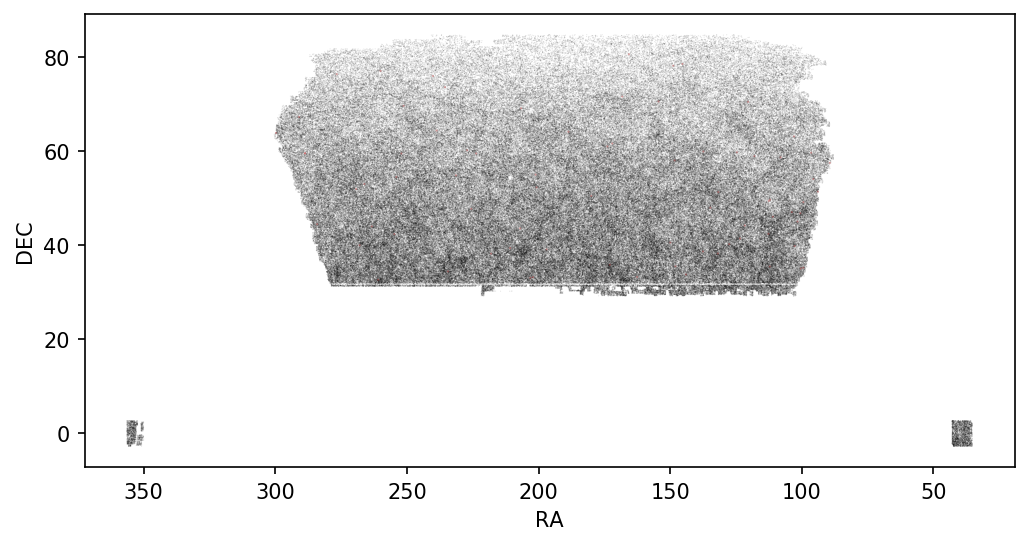

In [42]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(preds_north_extended.RA, preds_north_extended.DEC, s=0.3, color='k', edgecolor='none', alpha=0.1)
plt.scatter(preds_north_extended[preds_north_extended.p_CNN > 0.5].RA, preds_north_extended[preds_north_extended.p_CNN > 0.5].DEC, s=1, color='C3', edgecolor='none', alpha=0.3)

plt.xlim(*reversed(plt.xlim()))
plt.xlabel('RA')
plt.ylabel('DEC')

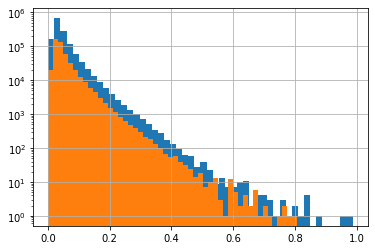

In [40]:
preds_south_extended.p_CNN.hist(bins=50, log=True)
preds_north_extended.p_CNN.hist(bins=50, log=True)

Text(0, 0.5, 'DEC')

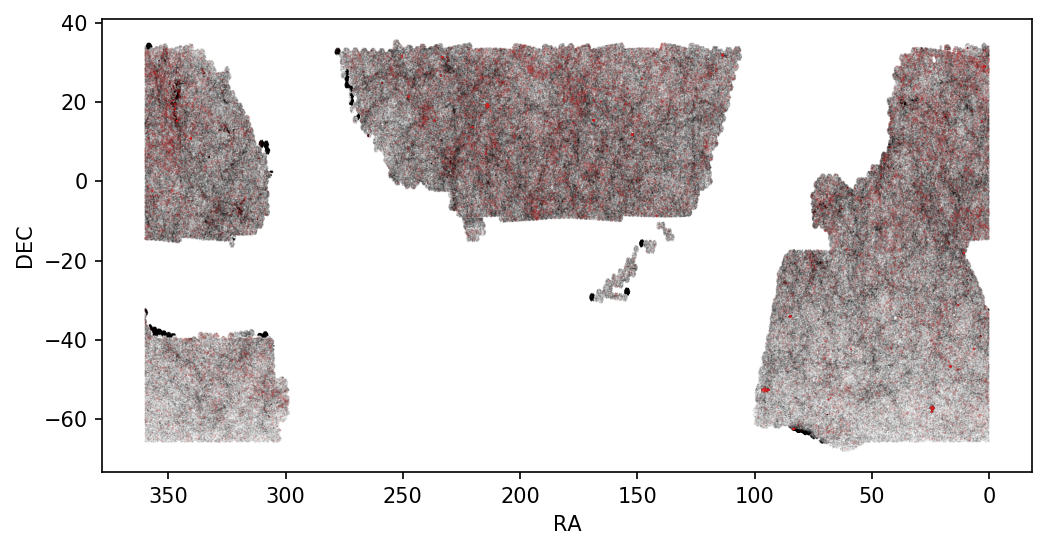

In [51]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(preds_south_extended.RA, preds_south_extended.DEC, s=0.3, color='k', edgecolor='none', alpha=0.03)
plt.scatter(preds_south_extended[preds_south_extended.p_CNN > 0.5].RA, preds_south_extended[preds_south_extended.p_CNN > 0.5].DEC, s=1, color='C3', edgecolor='none', alpha=0.1)

plt.xlim(*reversed(plt.xlim()))
plt.xlabel('RA')
plt.ylabel('DEC')

# Combine predictions with previous catalogs

In [79]:
dne = pd.read_csv(PATH/'data/desi_low_z_extended_target_list_north_dr9.csv', index_col=0)
dne['objname'] = (dne.RA * 1000000).astype(int).astype(str) + (dne.DEC * 1000000).astype(int).astype(str)

preds_north_extended = (
    pd.read_csv(PATH/'results/desi-lowz/north_extended-only_CNN-hdx34-sz144_2021-03-20.csv', dtype={'objname': str})
        .reset_index()
    .join(dne.set_index('objname'), on='objname', how='inner')
)

In [80]:
dse = pd.read_csv(PATH/'data/desi_low_z_extended_target_list_south_dr9.csv', index_col=0)
dse['objname'] = (dse.RA * 1000000).astype(int).astype(str) + (dse.DEC * 1000000).astype(int).astype(str)

preds_south_extended = (
    pd.read_csv(PATH/'results/desi-lowz/south_extended-only_CNN-hdx34-sz144_2021-03-20.csv', dtype={'objname': str})
        .reset_index()
    .join(dse.set_index('objname'), on='objname', how='inner')
)

/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Load original predictions from nb `21`.

In [81]:
dn = pd.read_csv(PATH/'data/desi_low_z_target_list_north_dr9.csv', index_col=0)
dn['objname'] = (dn.RA * 1000000).astype(int).astype(str) + (dn.DEC * 1000000).astype(int).astype(str)

preds_north = (
    pd.read_csv(PATH/'results/desi-lowz/north_CNN-hdx34-sz144_2021-03-05.csv', dtype={'objname': str})
        .reset_index()
    .join(dn.set_index('objname'), on='objname', how='inner')
)


In [82]:
ds = pd.read_csv(PATH/'data/desi_low_z_target_list_south_dr9.csv', index_col=0)
ds['objname'] = (ds.RA * 1000000).astype(int).astype(str) + (ds.DEC * 1000000).astype(int).astype(str)

preds_south = (
    pd.read_csv(PATH/'results/desi-lowz/south_CNN-hdx34-sz144_2021-03-05.csv', dtype={'objname': str})
        .reset_index()
    .join(ds.set_index('objname'), on='objname', how='inner')
)


I think there are a small number of duplicates between the north and south catalog (~100)

In [18]:
preds_north_extended.shape, preds_north.shape

((464128, 150), (766869, 151))

In [19]:
preds_south_extended.shape, preds_south.shape

((1390916, 151), (2573899, 151))

In [88]:
# add simple flag to tell which ones extend beyond SAGA II cuts
preds_north['extended'] = 0
preds_north_extended['extended'] = 1

preds_south['extended'] = 0
preds_south_extended['extended'] = 1

In [89]:
# combine
preds_north_all = pd.concat([preds_north, preds_north_extended])
preds_south_all = pd.concat([preds_south, preds_south_extended])


In [22]:
preds_north_all.objname.duplicated().sum(), preds_south_all.objname.duplicated().sum()

(0, 0)

In [91]:
columns = ['objname', 'RA', 'DEC', 'r_mag', 'extended', 'p_CNN']

pna = preds_north_all[columns]
psa = preds_south_all[columns]

In [92]:
# save all preds
pna.sort_values('p_CNN', ascending=False).to_csv(PATH/'results/desi-lowz/north_extended_preds.csv', index=False)
psa.sort_values('p_CNN', ascending=False).to_csv(PATH/'results/desi-lowz/south_extended_preds.csv', index=False)

# ~~Applying additional quality cuts~~ (sending 20/sq deg)

This is what Elise sent me:

```python
def _n_or_more_gt(cols, n, cut):
    def _n_or_more_gt_this(*arrays, n=n, cut=cut):
        return np.count_nonzero((np.stack(arrays) > cut), axis=0) >= n
    return Query((_n_or_more_gt_this,) + tuple(cols))

def _n_or_more_lt(cols, n, cut):
    def _n_or_more_lt_this(*arrays, n=n, cut=cut):
        return np.count_nonzero((np.stack(arrays) < cut), axis=0) >= n
    return Query((_n_or_more_lt_this,) + tuple(cols))
sigma_grz = [f"SIGMA_GOOD_{b}" for b in "GRZ"]
sigma_wise = [f"SIGMA_GOOD_W{b}" for b in range(1, 5)]
fracmasked_grz = [f"FRACMASKED_{b}" for b in "GRZ"]
fracflux_grz = [f"FRACFLUX_{b}" for b in "GRZ"]
rchisq_grz = [f"RCHISQ_{b}" for b in "GRZ"]
def get_remove_flag(catalog, remove_queries):
    """
    get remove flag by remove queries. remove_queries can be a list or dict.
    """
    try:
        iter_queries = iter(remove_queries.items())
    except AttributeError:
        iter_queries = enumerate(remove_queries)
    remove_flag = np.zeros(len(catalog), dtype=np.int)
    for i, remove_query in iter_queries:
        remove_flag[Query(remove_query).mask(catalog)] += 1 << i
    return remove_flag


remove_queries = [
    "(MASKBITS >> 1) % 2 > 0",  # 1
    "(MASKBITS >> 5) % 2 > 0",  # 2
    "(MASKBITS >> 6) % 2 > 0",  # 3
    "(MASKBITS >> 7) % 2 > 0",  # 4
    "(MASKBITS >> 12) % 2 > 0",  # 5
    "(MASKBITS >> 13) % 2 > 0",  # 6
    _n_or_more_lt(sigma_grz, 2, 5),  # 7
    Query(_n_or_more_gt(fracflux_grz, 2, 0.35)),  # 8
    Query(_n_or_more_gt(rchisq_grz, 2, 2)),  # 9
    Query(_n_or_more_lt(sigma_grz, 2, 30), _n_or_more_gt(rchisq_grz, 2, 0.85)),  # 10
    "g_mag - r_mag <= -0.1",  # 11
]
```

In [59]:
# preds_north_all = preds_north_all[preds_north_all.MASKBITS.notnull()].copy()
# preds_north_all.MASKBITS = preds_north_all.MASKBITS.astype(int)

# preds_north_all.shape

(766869, 151)

In [71]:
# preds_south_all = preds_south_all[preds_south_all.MASKBITS.notnull()].copy()
# preds_south_all.MASKBITS = preds_south_all.MASKBITS.astype(int)

# preds_south_all.shape

(2573899, 151)

In [27]:
preds_north_all.drop('index', axis=1, inplace=True)
preds_south_all.drop('index', axis=1, inplace=True)

In [28]:
preds_south_all.shape

(3964815, 151)

In [29]:
preds_south_all.head()

,objname,p_CNN,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,...,r_fib_mag,u_mag,u_err,i_mag,i_err,mu_r,mu_r_err,bgs,extended,Unnamed: 0.1
0,6261736-144057,0.334684,9010,328953,b'0063m002',517,b'SER',6.261736,-0.144057,2.105924e+11,...,22.527137,99.0,99.0,99.0,99.0,24.487513,0.026135,False,0,NaN
1,6283237-160819,0.019350,9010,328953,b'0063m002',1319,b'SER',6.283237,-0.160820,4.487618e+11,...,21.605339,99.0,99.0,99.0,99.0,23.717109,0.018577,False,0,NaN
2,6291097-245064,0.147852,9010,328953,b'0063m002',1605,b'SER',6.291098,-0.245064,6.258617e+11,...,21.685894,99.0,99.0,99.0,99.0,23.620029,0.008111,True,0,NaN
3,6305571-153063,0.112688,9010,328953,b'0063m002',2144,b'EXP',6.305571,-0.153063,1.100458e+11,...,22.531761,99.0,99.0,99.0,99.0,23.964948,0.021715,False,0,NaN
4,6340718-326017,0.034278,9010,328953,b'0063m002',3483,b'SER',6.340718,-0.326017,1.510274e+11,...,22.413052,99.0,99.0,99.0,99.0,23.676133,0.009471,False,0,NaN


In [32]:
# save top 20/sq deg
preds_north_all.sort_values('p_CNN', ascending=False).head(100000).to_csv(PATH/'results/desi-lowz/north_extended-CNN_preds_20-per-sq-deg.csv', index=False)
preds_south_all.sort_values('p_CNN', ascending=False).head(180000).to_csv(PATH/'results/desi-lowz/south_extended-CNN_preds_20-per-sq-deg.csv', index=False)

# Predicting 15 targets per square degree

According to Dey et al., the north is 5000 sq deg (BASS+MzLS) and the south is 9000 (DECaLS). At 15 per square degree, we want **75k** and **135k** respectively

In [110]:
for thresh in [0.7, 0.6, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2]:
    print(f'{thresh:.2f} | {sum(pna.p_CNN > thresh):> 7d} | {sum(psa.p_CNN > thresh):> 7d}')

0.70 |    1489 |    4937
0.60 |    5487 |   17313
0.50 |   15276 |   47540
0.40 |   35101 |  109379
0.35 |   50288 |  157539
0.30 |   71030 |  221265
0.25 |  100235 |  308292
0.20 |  145689 |  438126


In [70]:
# save top 15/sq deg (files are a couple hundred MB)
preds_north_all.sort_values('p_CNN', ascending=False).head(75000).to_csv(PATH/'results/desi-lowz/north_extended-CNN_preds_15-per-sq-deg.csv', index=False)
preds_south_all.sort_values('p_CNN', ascending=False).head(135000).to_csv(PATH/'results/desi-lowz/south_extended-CNN_preds_15-per-sq-deg.csv', index=False)

KeyboardInterrupt: 

## Visualizing some of the new extended-SAGA cut sources

In [103]:
# for visualizing some of the extended sources
pna[pna.extended == 1].head(50).set_index('objname', drop=True)

,RA,DEC,extended,p_CNN
objname,,,,
16565753480591448,165.657535,80.591448,1,0.808323
27665627776360120,276.656278,76.360121,1,0.783589
9643069159665926,96.430691,59.665926,1,0.768406
28874964559549828,288.749645,59.549828,1,0.768121
10292178763128472,102.921787,63.128473,1,0.758834
20662109169113151,206.621091,69.113152,1,0.717158
26615451653009768,266.154516,53.009769,1,0.706633
28868877959550070,288.688779,59.550070,1,0.696910
9388601151392964,93.886011,51.392964,1,0.690797


In [105]:
psa[psa.extended == 1].sort_values('p_CNN', ascending=False).head(50).set_index('objname', drop=True)

,RA,DEC,extended,p_CNN
objname,,,,
21373381818841744,213.733819,18.841744,1,0.987328
6639147-42216238,6.639148,-42.216239,1,0.961501
95285032-52643698,95.285033,-52.643699,1,0.877069
23819644-57144109,23.819644,-57.144110,1,0.844276
23944730-57123955,23.944730,-57.123955,1,0.843444
3516226611957522,351.622662,1.957523,1,0.843366
23948738-57134906,23.948739,-57.134907,1,0.830172
23894848-57290653,23.894848,-57.290653,1,0.828186
21375228018894655,213.752281,18.894656,1,0.806068


## What fraction are "extended" by `p_CNN`?

In [107]:
for thresh in [0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2]:
    print(f'{thresh:.2f} | {sum(pna[pna.extended==1].p_CNN > thresh) / sum(pna.p_CNN > thresh):> 4f} | {sum(psa[psa.extended==1].p_CNN > thresh) / sum(psa.p_CNN > thresh):> 4f}')

0.70 |  0.004701 |  0.003646
0.60 |  0.005103 |  0.002830
0.50 |  0.005041 |  0.002692
0.40 |  0.007692 |  0.004343
0.30 |  0.015965 |  0.010928
0.25 |  0.024931 |  0.017954
0.20 |  0.039639 |  0.029507


In [111]:
print([c for c in preds_north_all.columns])

['index', 'objname', 'p_CNN', 'RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4', 'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_Z', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'WISEMASK_W1', 'WISEMASK_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GAL

In [114]:
preds_south_all.sort_values('p_CNN', ascending=False).iloc[135000].p_CNN

0.37155014

# Checking 20 / sq deg predictions


In [33]:
preds_north_all = pd.read_csv(PATH/'results/desi-lowz/north_extended-CNN_preds_20-per-sq-deg.csv')
preds_south_all = pd.read_csv(PATH/'results/desi-lowz/south_extended-CNN_preds_20-per-sq-deg.csv')

## Duplicates

In [35]:
preds_north_all[preds_north_all.extended == 0].shape, preds_north_all[preds_north_all.extended == 1].shape

((97518, 150), (2482, 150))

In [36]:
preds_south_all[preds_south_all.extended == 0].shape, preds_south_all[preds_south_all.extended == 1].shape

((178561, 151), (1439, 151))

In [38]:
preds_north_all[preds_north_all.extended == 1][['RA', 'DEC', 'p_CNN']].sample(20)

,RA,DEC,p_CNN
64161,167.228892,79.895392,0.315119
60584,165.050890,40.151812,0.323438
40629,175.351442,43.840431,0.380049
99955,271.229456,77.378590,0.250361
78194,174.689830,50.762197,0.285806
62895,156.949433,67.690116,0.317980
35733,278.443131,32.216725,0.397566
49289,146.599597,79.875510,0.352845
60964,180.033913,44.888275,0.322526
35776,198.366810,40.134085,0.397408


In [39]:
preds_south_all[preds_south_all.extended == 1][['RA', 'DEC', 'p_CNN']].sample(20)

,RA,DEC,p_CNN
36001,145.324216,27.782275,0.529666
86173,356.510502,7.705829,0.430362
147793,325.700091,25.998790,0.358954
49752,338.369950,13.670317,0.494782
174335,191.550687,8.409185,0.335492
132644,148.107322,11.950285,0.374004
159001,333.938234,17.704819,0.348709
161204,246.095480,28.629383,0.346697
178586,13.795248,-10.939625,0.331983
152654,337.790129,13.408003,0.354400


## Number density by r_mag

(0, 1)

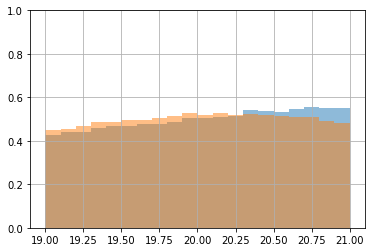

In [99]:
pna.sort_values('p_CNN', ascending=False).head(100000).r_mag.hist(bins=20, density=True, alpha=0.5)
psa.sort_values('p_CNN', ascending=False).head(180000).r_mag.hist(bins=20, density=True, alpha=0.5)
plt.ylim(0, 1)

Text(0.5, 1.0, 'North')

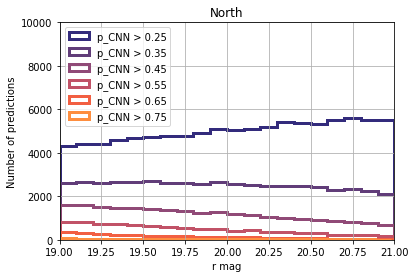

In [124]:
for p_CNN in np.arange(0.25, 0.85, 0.1):
    cut = pna.p_CNN > p_CNN
    pna[cut].r_mag.hist(bins=20, density=False, histtype='step', color=cmr.heat(p_CNN), log=False, lw=3, label=f'p_CNN > {p_CNN:.2f}')
plt.xlim(19, 21)
plt.ylim(0, 1e4)
plt.legend(loc='upper left')

plt.xlabel('r mag')
plt.ylabel('Number of predictions')
plt.title('North')

Text(0.5, 1.0, 'South')

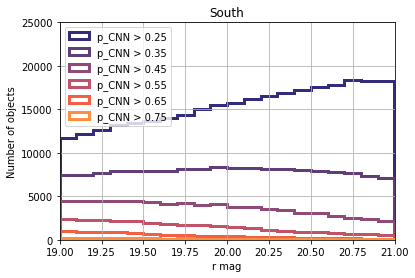

In [120]:
for p_CNN in np.arange(0.25, 0.85, 0.1):
    cut = psa.p_CNN > p_CNN
    psa[cut].r_mag.hist(bins=20, density=False, histtype='step', color=cmr.heat(p_CNN), log=False, lw=3, label=f'p_CNN > {p_CNN:.2f}')
plt.xlim(19, 21)
plt.ylim(0, 2.5e4)
plt.legend(loc='upper left')

plt.xlabel('r mag')
plt.ylabel('Number of objects')
plt.title('South')

Text(0.5, 1.0, 'North')

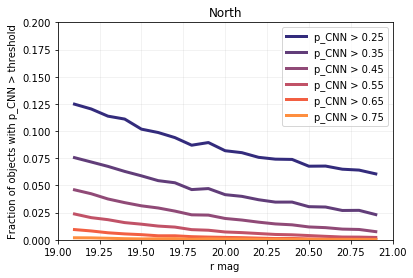

In [113]:
mag_bins = np.arange(19.05, 21, 0.1)

for p_CNN in np.arange(0.25, 0.85, 0.1):
    cut = pna.p_CNN > p_CNN
    frac = [sum((pna[cut].r_mag > m1) & (pna[cut].r_mag < m2)) / sum((pna.r_mag > m1) & (pna.r_mag < m2)) for m1, m2 in zip(mag_bins[:-1], mag_bins[1:])]

    plt.plot((mag_bins[:-1]+mag_bins[1:])/2, frac, color=cmr.heat(p_CNN), lw=3, label=f'p_CNN > {p_CNN:.2f}')
plt.xlim(19, 21)
plt.ylim(0, 0.2)
plt.legend(loc='upper right')
plt.grid(alpha=0.2)

plt.xlabel('r mag')
plt.ylabel('Fraction of objects with p_CNN > threshold')
plt.title('North')

Text(0.5, 1.0, 'South')

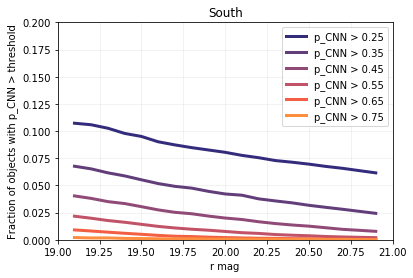

In [114]:
mag_bins = np.arange(19.05, 21, 0.1)

for p_CNN in np.arange(0.25, 0.85, 0.1):
    cut = psa.p_CNN > p_CNN
    frac = [sum((psa[cut].r_mag > m1) & (psa[cut].r_mag < m2)) / sum((psa.r_mag > m1) & (psa.r_mag < m2)) for m1, m2 in zip(mag_bins[:-1], mag_bins[1:])]

    plt.plot((mag_bins[:-1]+mag_bins[1:])/2, frac, color=cmr.heat(p_CNN), lw=3, label=f'p_CNN > {p_CNN:.2f}')
plt.xlim(19, 21)
plt.ylim(0, 0.2)
plt.legend(loc='upper right')
plt.grid(alpha=0.2)

plt.xlabel('r mag')
plt.ylabel('Fraction of objects with p_CNN > threshold')
plt.title('South')

Text(0, 0.5, 'DEC')

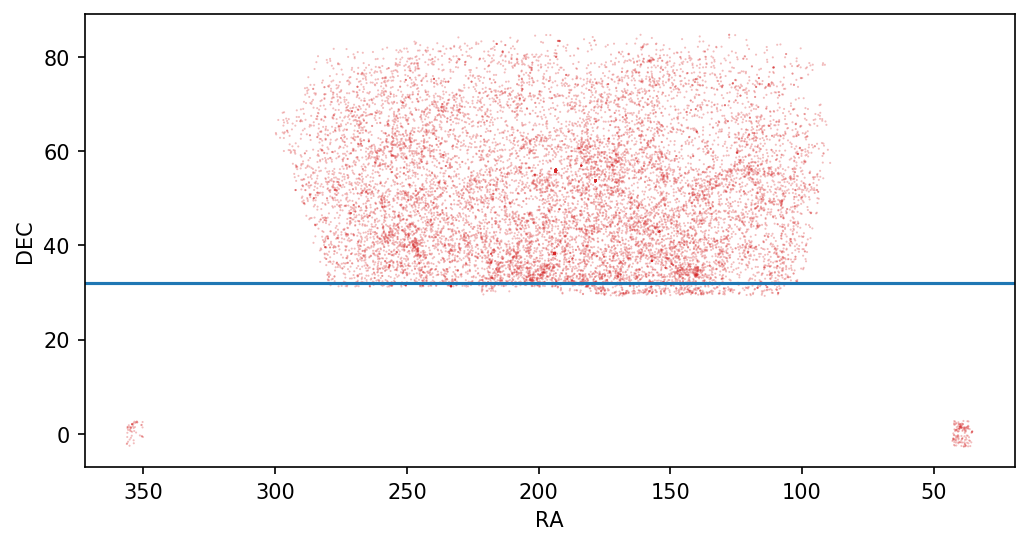

In [50]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(preds_north_all[preds_north_all.p_CNN > 0.5].RA, preds_north_all[preds_north_all.p_CNN > 0.5].DEC, s=1, color='C3', edgecolor='none', alpha=0.3)
plt.axhline(32)
plt.xlim(*reversed(plt.xlim()))
plt.xlabel('RA')
plt.ylabel('DEC')

Text(0, 0.5, 'DEC')

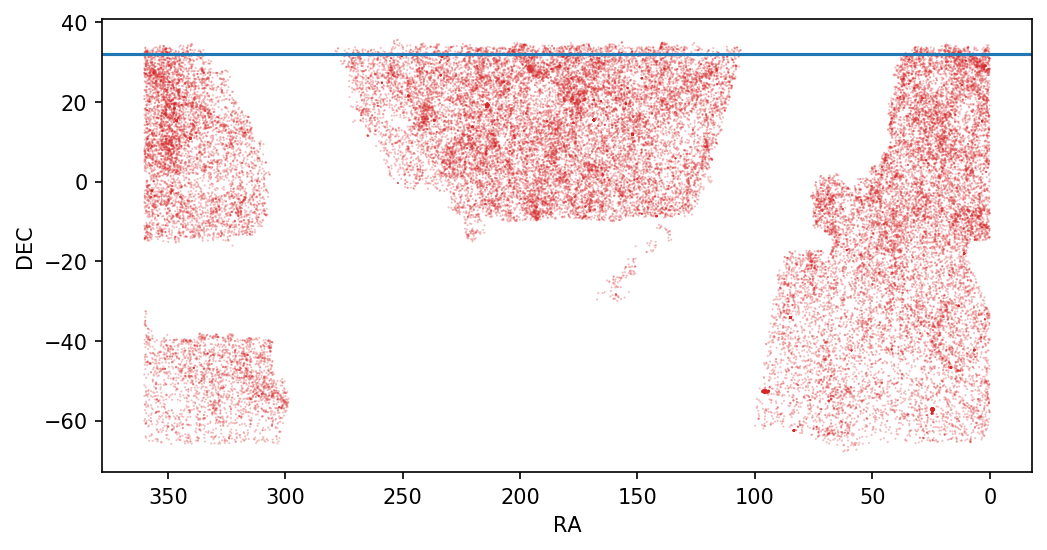

In [49]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(preds_south_all[preds_south_all.p_CNN > 0.5].RA, preds_south_all[preds_south_all.p_CNN > 0.5].DEC, s=1, color='C3', edgecolor='none', alpha=0.3)
plt.axhline(32)
plt.xlim(*reversed(plt.xlim()))
plt.xlabel('RA')
plt.ylabel('DEC')